In [5]:
import os
import cv2
import torch
import torchvision
import torch.nn as nn
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
from torchvision.utils import save_image
import torch.nn.functional as F

from IPython.display import Image
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

In [139]:
DATA_DIR = 'data/dress_dataset/'
print(os.listdir(DATA_DIR))
print(os.listdir(DATA_DIR+'/images')[:10])

['images']
['10000.jpg', '10001.jpg', '10002.jpg', '10003.jpg', '10004.jpg', '10005.jpg', '10006.jpg', '10007.jpg', '10008.jpg', '10009.jpg']


In [ ]:
## Data Loading

In [140]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [141]:
train_ds = ImageFolder(DATA_DIR, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

In [142]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [143]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

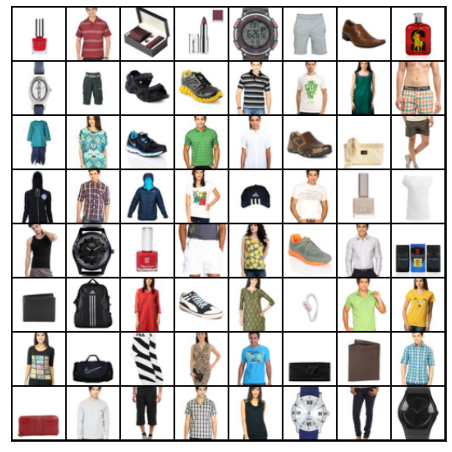

In [144]:
show_batch(train_dl)

In [8]:
## using GPU

In [145]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [146]:
device = get_default_device()
device

device(type='cuda')

In [147]:
train_dl = DeviceDataLoader(train_dl, device)

In [12]:
## Discriminator Network

In [148]:
def ConvBlock(in_channels, out_channels, kernel_size = 4, stride = 2, padding = 1, pool = False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias = False),
              nn.BatchNorm2d(out_channels),
              nn.LeakyReLU(0.2, inplace = True)]
    if pool:
        layers.append(nn.MaxPool2d(kernel_size = 2, stride = 2))
    return nn.Sequential(*layers)


def ResBlock(channels):
    return nn.Sequential(ConvBlock(channels, channels, kernel_size = 3, stride = 1, padding = 1),
                         ConvBlock(channels, channels, kernel_size = 3, stride = 1, padding = 1))

In [149]:
class Discriminator(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        
        self.conv1 = ConvBlock(in_channels, 64)
        self.conv2 = ConvBlock(64, 128)
        self.res1 = ResBlock(128)
        
        self.conv3 = ConvBlock(128, 256)
        self.conv4 = ConvBlock(256, 512)
        self.res2 = ResBlock(512)
        
        self.output = nn.Sequential(nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
                                    nn.Flatten(),
                                    nn.Sigmoid())
        
        
    def forward(self, xb):
        
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.output(out)
        
        return out

In [150]:
discriminator = to_device(Discriminator(3), device)
discriminator

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_r

In [111]:
## Generator Network

In [153]:
latent_size = 128

In [154]:
def TransConvBlock(in_channels, out_channels, kernel_size = 4, stride = 2, padding = 1, pool = False):
    layers = [nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias = False),
              nn.BatchNorm2d(out_channels),
              nn.ReLU(True)]
    if pool:
        layers.append(nn.MaxPool2d(kernel_size = 2, stride = 2))
    return nn.Sequential(*layers)


def TransResBlock(channels):
    return nn.Sequential(TransConvBlock(channels, channels, kernel_size = 3, stride = 1, padding = 1),
                         TransConvBlock(channels, channels, kernel_size = 3, stride = 1, padding = 1))

In [155]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.trconv1 = TransConvBlock(latent_size, 512, stride=1, padding=0)
        self.trconv2 = TransConvBlock(512, 256)
        self.trres1 = TransResBlock(256)
        
        self.trconv3 = TransConvBlock(256, 128)
        self.trconv4 = TransConvBlock(128, 64)
        self.trres2 = TransResBlock(64)
        
        self.troutput = nn.Sequential(nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
                                      nn.Tanh())
        
        
    def forward(self, xb):
        
        out = self.trconv1(xb)
        out = self.trconv2(out)
        out = self.trres1(out) + out
        out = self.trconv3(out)
        out = self.trconv4(out)
        out = self.trres2(out) + out
        out = self.troutput(out)
        
        return out

In [ ]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [166]:
generator = to_device(Generator(), device)
generator

Generator(
  (trconv1): Sequential(
    (0): ConvTranspose2d(128, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (trconv2): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (trres1): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): ConvTranspose2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)

In [297]:
## For loading trained discriminator and generator models

#discriminator.load_state_dict(torch.load('GAN_generated/dress/D.pth'))
#generator.load_state_dict(torch.load('GAN_generated/dress/G.pth'))

<All keys matched successfully>

In [63]:
## Discriminator training

In [167]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [51]:
## Generator training

In [168]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

In [218]:
## Creating directory for saving

sample_dir = 'GAN_generated/dress'
os.makedirs(sample_dir, exist_ok=True)

In [170]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [171]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving generated-images-0000.png


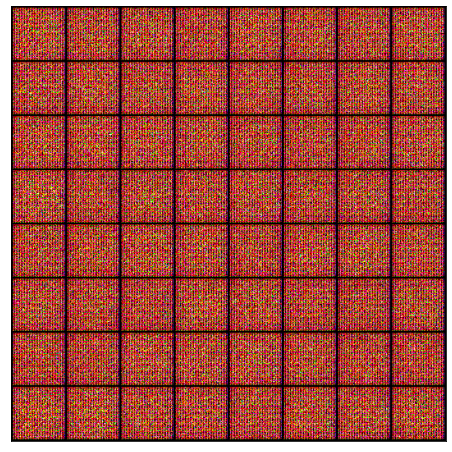

In [172]:
save_samples(0, fixed_latent)

In [85]:
## full training network

In [219]:
def fit(epochs, lr, start_idx = 1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [220]:
lr = 0.0002
epochs = 100

In [221]:
history = fit(epochs, lr)


Epoch [1/90], loss_g: 3.6471, loss_d: 1.9680, real_score: 0.2460, fake_score: 0.0063
Saving generated-images-0011.png



Epoch [2/90], loss_g: 0.4822, loss_d: 1.4687, real_score: 0.3208, fake_score: 0.1344
Saving generated-images-0012.png



Epoch [3/90], loss_g: 4.4055, loss_d: 0.2964, real_score: 0.8239, fake_score: 0.0474
Saving generated-images-0013.png



Epoch [4/90], loss_g: 10.6755, loss_d: 0.3656, real_score: 0.7294, fake_score: 0.0003
Saving generated-images-0014.png



Epoch [5/90], loss_g: 10.2744, loss_d: 1.1727, real_score: 0.7129, fake_score: 0.5001
Saving generated-images-0015.png



Epoch [6/90], loss_g: 0.8357, loss_d: 0.9360, real_score: 0.4444, fake_score: 0.0231
Saving generated-images-0016.png



Epoch [7/90], loss_g: 3.7805, loss_d: 0.3479, real_score: 0.8392, fake_score: 0.1324
Saving generated-images-0017.png



Epoch [8/90], loss_g: 1.2979, loss_d: 1.9105, real_score: 0.2835, fake_score: 0.2181
Saving generated-images-0018.png



Epoch [9/90], loss_g: 3.9620, loss_d: 0.2813, real_score: 0.8023, fake_score: 0.0031
Saving generated-images-0019.png



Epoch [10/90], loss_g: 4.6937, loss_d: 0.0917, real_score: 0.9592, fake_score: 0.0426
Saving generated-images-0020.png



Epoch [11/90], loss_g: 2.5881, loss_d: 0.5288, real_score: 0.7027, fake_score: 0.0248
Saving generated-images-0021.png



Epoch [12/90], loss_g: 4.9662, loss_d: 0.0399, real_score: 0.9929, fake_score: 0.0306
Saving generated-images-0022.png



Epoch [13/90], loss_g: 2.3706, loss_d: 0.3252, real_score: 0.7848, fake_score: 0.0156
Saving generated-images-0023.png



Epoch [14/90], loss_g: 4.5592, loss_d: 0.0400, real_score: 0.9782, fake_score: 0.0165
Saving generated-images-0024.png



Epoch [15/90], loss_g: 4.3579, loss_d: 0.0180, real_score: 0.9980, fake_score: 0.0154
Saving generated-images-0025.png



Epoch [16/90], loss_g: 0.0814, loss_d: 1.3375, real_score: 0.3334, fake_score: 0.0110
Saving generated-images-0026.png



Epoch [17/90], loss_g: 6.4708, loss_d: 0.0232, real_score: 0.9903, fake_score: 0.0132
Saving generated-images-0027.png



Epoch [18/90], loss_g: 5.8498, loss_d: 0.3687, real_score: 0.8398, fake_score: 0.1407
Saving generated-images-0028.png



Epoch [19/90], loss_g: 6.8308, loss_d: 0.0476, real_score: 0.9775, fake_score: 0.0238
Saving generated-images-0029.png



Epoch [20/90], loss_g: 5.0609, loss_d: 0.2054, real_score: 0.8529, fake_score: 0.0169
Saving generated-images-0030.png



Epoch [21/90], loss_g: 5.6524, loss_d: 0.1048, real_score: 0.9408, fake_score: 0.0393
Saving generated-images-0031.png



Epoch [22/90], loss_g: 3.3362, loss_d: 0.5051, real_score: 0.6481, fake_score: 0.0014
Saving generated-images-0032.png



Epoch [23/90], loss_g: 0.0024, loss_d: 2.4296, real_score: 0.1724, fake_score: 0.0102
Saving generated-images-0033.png



Epoch [24/90], loss_g: 14.7556, loss_d: 0.0008, real_score: 0.9993, fake_score: 0.0001
Saving generated-images-0034.png



Epoch [25/90], loss_g: 0.2123, loss_d: 1.8751, real_score: 0.2250, fake_score: 0.0118
Saving generated-images-0035.png



Epoch [26/90], loss_g: 0.0379, loss_d: 1.9029, real_score: 0.2068, fake_score: 0.0110
Saving generated-images-0036.png



Epoch [27/90], loss_g: 2.6165, loss_d: 0.3674, real_score: 0.7528, fake_score: 0.0468
Saving generated-images-0037.png



Epoch [28/90], loss_g: 0.0011, loss_d: 3.3528, real_score: 0.0498, fake_score: 0.0079
Saving generated-images-0038.png



Epoch [29/90], loss_g: 4.8646, loss_d: 0.3897, real_score: 0.9985, fake_score: 0.2611
Saving generated-images-0039.png



Epoch [30/90], loss_g: 0.0009, loss_d: 5.2525, real_score: 0.0201, fake_score: 0.0013
Saving generated-images-0040.png



Epoch [31/90], loss_g: 0.2855, loss_d: 3.3895, real_score: 0.0741, fake_score: 0.1622
Saving generated-images-0041.png



Epoch [32/90], loss_g: 4.0558, loss_d: 0.1671, real_score: 0.9338, fake_score: 0.0902
Saving generated-images-0042.png



Epoch [33/90], loss_g: 4.1926, loss_d: 0.0587, real_score: 0.9888, fake_score: 0.0454
Saving generated-images-0043.png



Epoch [34/90], loss_g: 6.3352, loss_d: 0.1426, real_score: 0.9181, fake_score: 0.0494
Saving generated-images-0044.png



Epoch [35/90], loss_g: 3.4886, loss_d: 3.6677, real_score: 0.0875, fake_score: 0.0029
Saving generated-images-0045.png



Epoch [36/90], loss_g: 0.0042, loss_d: 4.2638, real_score: 0.0364, fake_score: 0.0247
Saving generated-images-0046.png



Epoch [37/90], loss_g: 0.0946, loss_d: 4.6869, real_score: 0.0170, fake_score: 0.0031
Saving generated-images-0047.png



Epoch [38/90], loss_g: 1.3764, loss_d: 4.1892, real_score: 0.0691, fake_score: 0.0005
Saving generated-images-0048.png



Epoch [39/90], loss_g: 0.1787, loss_d: 2.5343, real_score: 0.1518, fake_score: 0.0044
Saving generated-images-0049.png



Epoch [40/90], loss_g: 0.3533, loss_d: 4.2027, real_score: 0.0746, fake_score: 0.0037
Saving generated-images-0050.png



Epoch [41/90], loss_g: 2.3605, loss_d: 0.9074, real_score: 0.5055, fake_score: 0.0178
Saving generated-images-0051.png



Epoch [42/90], loss_g: 0.0179, loss_d: 4.0427, real_score: 0.0433, fake_score: 0.0179
Saving generated-images-0052.png



Epoch [43/90], loss_g: 2.6668, loss_d: 3.2774, real_score: 0.1663, fake_score: 0.0010
Saving generated-images-0053.png



Epoch [44/90], loss_g: 5.7053, loss_d: 0.2243, real_score: 0.9813, fake_score: 0.1652
Saving generated-images-0054.png



Epoch [45/90], loss_g: 0.4008, loss_d: 4.7249, real_score: 0.0426, fake_score: 0.0521
Saving generated-images-0055.png



Epoch [46/90], loss_g: 3.8927, loss_d: 0.0267, real_score: 0.9909, fake_score: 0.0168
Saving generated-images-0056.png



Epoch [47/90], loss_g: 0.0170, loss_d: 9.9560, real_score: 0.0001, fake_score: 0.0110
Saving generated-images-0057.png



Epoch [48/90], loss_g: 0.0081, loss_d: 5.2634, real_score: 0.0133, fake_score: 0.0048
Saving generated-images-0058.png



Epoch [49/90], loss_g: 0.3490, loss_d: 1.0013, real_score: 0.4397, fake_score: 0.0027
Saving generated-images-0059.png



Epoch [50/90], loss_g: 0.0305, loss_d: 8.5196, real_score: 0.0006, fake_score: 0.0761
Saving generated-images-0060.png



Epoch [51/90], loss_g: 5.0128, loss_d: 0.0666, real_score: 0.9996, fake_score: 0.0633
Saving generated-images-0061.png



Epoch [52/90], loss_g: 4.1265, loss_d: 0.5231, real_score: 0.6596, fake_score: 0.0017
Saving generated-images-0062.png



Epoch [53/90], loss_g: 0.0489, loss_d: 11.8873, real_score: 0.0000, fake_score: 0.0153
Saving generated-images-0063.png



Epoch [54/90], loss_g: 5.1599, loss_d: 0.1870, real_score: 0.8525, fake_score: 0.0115
Saving generated-images-0064.png



Epoch [55/90], loss_g: 1.0113, loss_d: 0.9624, real_score: 0.4685, fake_score: 0.1035
Saving generated-images-0065.png



Epoch [56/90], loss_g: 0.0082, loss_d: 7.5135, real_score: 0.0058, fake_score: 0.1316
Saving generated-images-0066.png



Epoch [57/90], loss_g: 0.0100, loss_d: 6.5449, real_score: 0.0093, fake_score: 0.0150
Saving generated-images-0067.png



Epoch [58/90], loss_g: 1.8223, loss_d: 0.4861, real_score: 0.6715, fake_score: 0.0264
Saving generated-images-0068.png



Epoch [59/90], loss_g: 0.1047, loss_d: 7.8743, real_score: 0.0009, fake_score: 0.0155
Saving generated-images-0069.png



Epoch [60/90], loss_g: 0.5081, loss_d: 5.3610, real_score: 0.0133, fake_score: 0.0239
Saving generated-images-0070.png



Epoch [61/90], loss_g: 1.5320, loss_d: 5.4464, real_score: 0.0158, fake_score: 0.0004
Saving generated-images-0071.png



Epoch [62/90], loss_g: 3.5815, loss_d: 0.0047, real_score: 0.9999, fake_score: 0.0045
Saving generated-images-0072.png



Epoch [63/90], loss_g: 6.2296, loss_d: 0.4983, real_score: 0.7214, fake_score: 0.0115
Saving generated-images-0073.png



Epoch [64/90], loss_g: 4.7373, loss_d: 0.0115, real_score: 0.9931, fake_score: 0.0045
Saving generated-images-0074.png



Epoch [65/90], loss_g: 0.7543, loss_d: 6.6936, real_score: 0.0027, fake_score: 0.0048
Saving generated-images-0075.png



Epoch [66/90], loss_g: 0.6149, loss_d: 10.5019, real_score: 0.0001, fake_score: 0.0003
Saving generated-images-0076.png



Epoch [67/90], loss_g: 2.9728, loss_d: 1.4512, real_score: 0.4322, fake_score: 0.2842
Saving generated-images-0077.png



Epoch [68/90], loss_g: 0.3105, loss_d: 2.9836, real_score: 0.1584, fake_score: 0.0842
Saving generated-images-0078.png



Epoch [69/90], loss_g: 0.0178, loss_d: 9.3747, real_score: 0.0002, fake_score: 0.0201
Saving generated-images-0079.png



Epoch [70/90], loss_g: 8.1137, loss_d: 0.0260, real_score: 0.9753, fake_score: 0.0006
Saving generated-images-0080.png



Epoch [71/90], loss_g: 2.2269, loss_d: 13.8431, real_score: 0.0000, fake_score: 0.0001
Saving generated-images-0081.png



Epoch [72/90], loss_g: 0.1296, loss_d: 3.0763, real_score: 0.0972, fake_score: 0.0059
Saving generated-images-0082.png



Epoch [73/90], loss_g: 0.0830, loss_d: 0.8462, real_score: 0.5135, fake_score: 0.0031
Saving generated-images-0083.png



Epoch [74/90], loss_g: 2.9189, loss_d: 0.4404, real_score: 0.7022, fake_score: 0.0189
Saving generated-images-0084.png



Epoch [75/90], loss_g: 5.8141, loss_d: 15.7048, real_score: 0.0000, fake_score: 0.0000
Saving generated-images-0085.png



Epoch [76/90], loss_g: 2.5886, loss_d: 8.5636, real_score: 0.0004, fake_score: 0.0000
Saving generated-images-0086.png



Epoch [77/90], loss_g: 7.8887, loss_d: 15.8467, real_score: 0.0000, fake_score: 0.0000
Saving generated-images-0087.png



Epoch [78/90], loss_g: 14.4796, loss_d: 0.8039, real_score: 0.8902, fake_score: 0.4434
Saving generated-images-0088.png



Epoch [79/90], loss_g: 10.4287, loss_d: 12.5266, real_score: 0.0000, fake_score: 0.0000
Saving generated-images-0089.png



Epoch [80/90], loss_g: 4.2206, loss_d: 0.2011, real_score: 0.9027, fake_score: 0.0038
Saving generated-images-0090.png



Epoch [81/90], loss_g: 0.0895, loss_d: 5.5713, real_score: 0.0130, fake_score: 0.0121
Saving generated-images-0091.png



Epoch [82/90], loss_g: 0.6529, loss_d: 10.5701, real_score: 0.0002, fake_score: 0.0081
Saving generated-images-0092.png



Epoch [83/90], loss_g: 4.9378, loss_d: 0.0325, real_score: 0.9871, fake_score: 0.0189
Saving generated-images-0093.png



Epoch [84/90], loss_g: 0.7191, loss_d: 4.2764, real_score: 0.0463, fake_score: 0.0031
Saving generated-images-0094.png



Epoch [85/90], loss_g: 5.2985, loss_d: 0.3665, real_score: 0.7512, fake_score: 0.0104
Saving generated-images-0095.png



Epoch [86/90], loss_g: 0.0041, loss_d: 7.4336, real_score: 0.0028, fake_score: 0.0199
Saving generated-images-0096.png



Epoch [87/90], loss_g: 4.5453, loss_d: 0.2415, real_score: 0.8437, fake_score: 0.0137
Saving generated-images-0097.png



Epoch [88/90], loss_g: 10.3609, loss_d: 0.0011, real_score: 0.9999, fake_score: 0.0010
Saving generated-images-0098.png



Epoch [89/90], loss_g: 0.2325, loss_d: 3.2361, real_score: 0.1143, fake_score: 0.0005
Saving generated-images-0099.png



Epoch [90/90], loss_g: 0.0465, loss_d: 4.0560, real_score: 0.0713, fake_score: 0.0031
Saving generated-images-0100.png


In [256]:
losses_g, losses_d, real_scores, fake_scores = history

In [228]:
# Save the model checkpoints

In [261]:
torch.save(generator.state_dict(), 'GAN_generated/dress/G.pth')
torch.save(discriminator.state_dict(), 'GAN_generated/dress/D.pth')

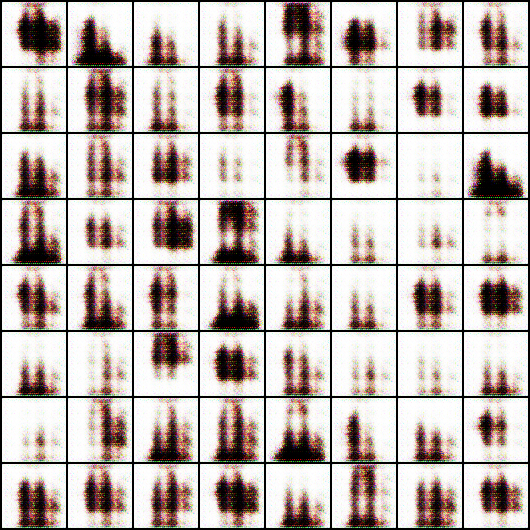

In [3]:
Image('GAN_generated/dress/generated-images-0001.png')

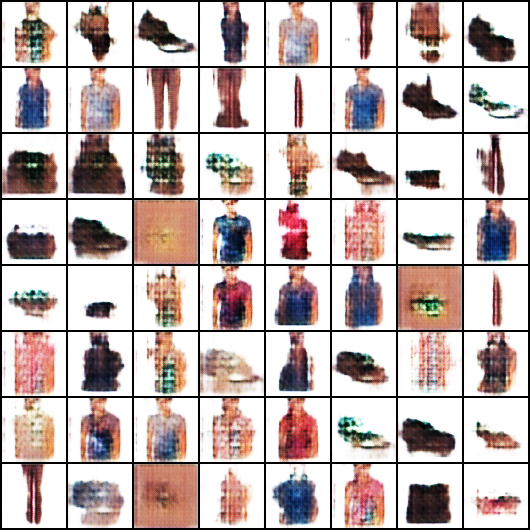

In [4]:
Image('GAN_generated/dress/generated-images-0005.png')

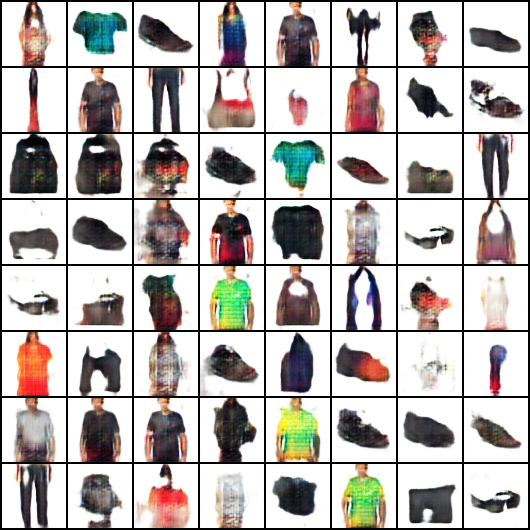

In [2]:
Image('GAN_generated/dress/generated-images-0010.png')

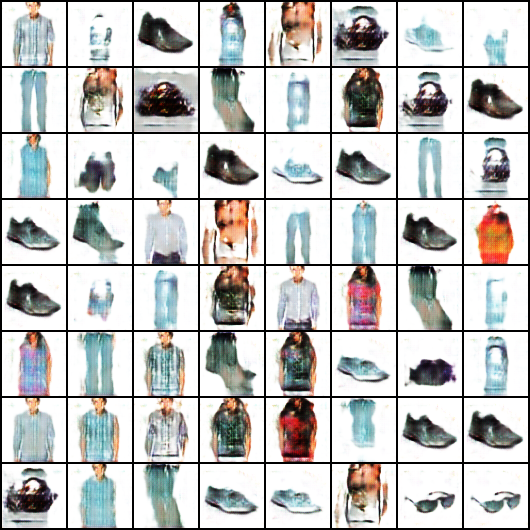

In [265]:
Image('GAN_generated/dress/generated-images-0030.png')

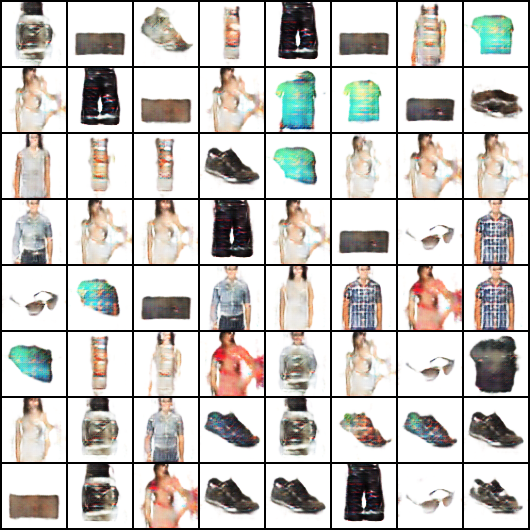

In [266]:
Image('GAN_generated/dress/generated-images-0050.png')

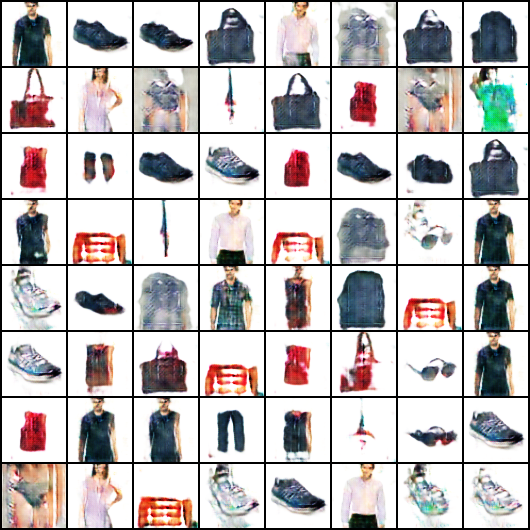

In [267]:
Image('GAN_generated/dress/generated-images-0070.png')

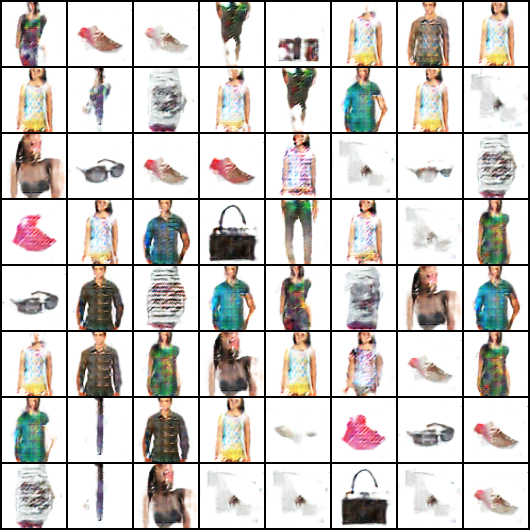

In [269]:
Image('GAN_generated/dress/generated-images-0100.png')

In [11]:
sample_dir = 'GAN_generated/dress_14'
vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()

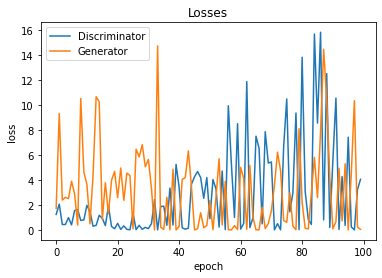

In [270]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

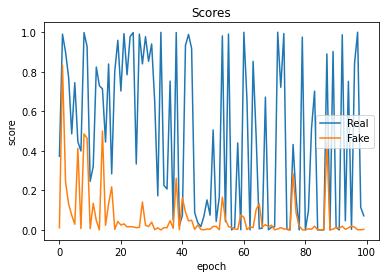

In [271]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');

In [ ]:
## single fake image from the generator

In [277]:
size = torch.randn(64,128,1,1, device = device)

In [278]:
fake = generator(size)

In [281]:
f = denorm(fake)

In [300]:
save_image(f[7], 'fake.jpg')

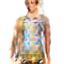

In [301]:
Image('fake.jpg')